In [2]:
import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import Tuple, List

In [3]:
df = pd.read_csv("./data/household_power_consumption_daily.csv", parse_dates=True, index_col=0)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


In [4]:
def split_data(data: numpy) -> Tuple[numpy.array, numpy.array]:
    train, test = data[1: -328], data[-328:-6]
    train = numpy.array(numpy.split(train, len(train)/7))
    test = numpy.array(numpy.split(test, len(test)/7))
    return train, test

In [5]:
train, test = split_data(df.values)
train.shape, test.shape

((159, 7, 8), (46, 7, 8))

In [6]:
def reshape_nn_input(x: numpy, n_input: int, n_output):
    data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    X, y = list(), list()
    first_index = 0
    for _ in range(len(data)):
        in_len = first_index + n_input
        target_len = in_len + n_output
        if target_len <= len(data):
            x_input = data[first_index:in_len, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_len:target_len, 0])
        first_index += 1
    return numpy.array(X), numpy.array(y)

In [7]:
x_train, y_train = reshape_nn_input(x=train, n_input=7, n_output=7)
x_train.shape, y_train.shape

((1100, 7, 1), (1100, 7))

In [8]:
def lstm_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.LSTM(100, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.Dense(50, activation=keras.activations.relu))
    model.add(keras.layers.Dense(num_outputs))

    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=70, batch_size=16, verbose=2)
    return history, model

In [9]:
history, model = lstm_model(x_train, y_train)

2023-01-05 15:58:14.844941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-05 15:58:14.844965: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-05 15:58:14.844985: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vhyne): /proc/driver/nvidia/version does not exist
2023-01-05 15:58:14.845268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/70
69/69 - 1s - loss: 1371273.1250 - 1s/epoch - 20ms/step
Epoch 2/70
69/69 - 0s - loss: 273727.9375 - 237ms/epoch - 3ms/step
Epoch 3/70
69/69 - 0s - loss: 269514.7812 - 251ms/epoch - 4ms/step
Epoch 4/70
69/69 - 0s - loss: 272039.4375 - 229ms/epoch - 3ms/step
Epoch 5/70
69/69 - 0s - loss: 267780.6250 - 230ms/epoch - 3ms/step
Epoch 6/70
69/69 - 0s - loss: 266936.9375 - 226ms/epoch - 3ms/step
Epoch 7/70
69/69 - 0s - loss: 268276.1562 - 227ms/epoch - 3ms/step
Epoch 8/70
69/69 - 0s - loss: 262788.0312 - 238ms/epoch - 3ms/step
Epoch 9/70
69/69 - 0s - loss: 266818.5938 - 240ms/epoch - 3ms/step
Epoch 10/70
69/69 - 0s - loss: 261956.8281 - 227ms/epoch - 3ms/step
Epoch 11/70
69/69 - 0s - loss: 263302.3750 - 228ms/epoch - 3ms/step
Epoch 12/70
69/69 - 0s - loss: 256324.7344 - 233ms/epoch - 3ms/step
Epoch 13/70
69/69 - 0s - loss: 258962.0625 - 266ms/epoch - 4ms/step
Epoch 14/70
69/69 - 0s - loss: 262315.9688 - 225ms/epoch - 3ms/step
Epoch 15/70
69/69 - 0s - loss: 259053.0000 - 223ms/epoch -

In [15]:
def model_prediction(model, x: numpy, n_inputs=7):
    # data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    # print(data.shape)

    last_week = x[-1:][:,:,0]
    print(last_week.shape)
    last_week = last_week.reshape((1, last_week.shape[1], 1))

    yhat = model.predict(last_week, verbose=1)

    return yhat

In [16]:
train[-1:]

array([[[2.1954520e+03, 2.0716400e+02, 3.4943910e+05, 9.1652000e+03,
         4.2180000e+03, 3.1800000e+02, 1.2450000e+04, 1.9604867e+04],
        [2.0940980e+03, 1.8166800e+02, 3.5103975e+05, 8.6880000e+03,
         2.1750000e+03, 2.0630000e+03, 1.4934000e+04, 1.5729633e+04],
        [2.0479680e+03, 2.4205000e+02, 3.5018353e+05, 8.5142000e+03,
         1.2600000e+03, 3.4600000e+02, 1.0205000e+04, 2.2321800e+04],
        [2.4511100e+03, 2.6679400e+02, 3.4711522e+05, 1.0322600e+04,
         5.2840000e+03, 4.5390000e+03, 1.2484000e+04, 1.8544834e+04],
        [2.2118920e+03, 1.8661200e+02, 3.4698070e+05, 9.2184000e+03,
         0.0000000e+00, 3.8700000e+02, 1.9409000e+04, 1.7068867e+04],
        [1.2242520e+03, 1.6533600e+02, 3.4929462e+05, 5.0934000e+03,
         2.3040000e+03, 3.2700000e+02, 3.5580000e+03, 1.4215200e+04],
        [1.3092680e+03, 1.9954600e+02, 3.5233284e+05, 5.4898000e+03,
         8.0100000e+02, 2.9800000e+02, 6.4250000e+03, 1.4297134e+04]]])

In [17]:
train[-1:][:,:,0].shape

(1, 7)

In [18]:
yhat = model_prediction(model=model, x=train)

(1, 7)
1/1 [==============================] - 0s 224ms/step


In [19]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[1]
    return numpy.reshape(array, (array_multiplication,))

In [20]:
yhat_values = flatten_shape(yhat)

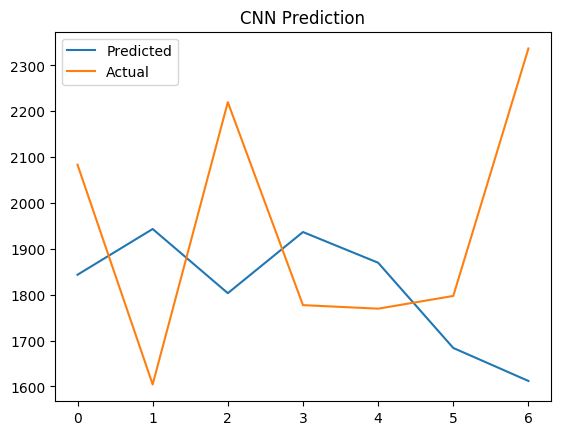

In [21]:
plt.figure()
plt.plot(yhat_values, label="Predicted")
plt.plot(test[0][:,0], label="Actual")
plt.title("CNN Prediction")
plt.legend()
plt.show()

In [22]:
def rmse_evaluation(actual: numpy, predicted: numpy):
    scores = list()

    for i in range(actual.shape[1]):
        rmse = numpy.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = numpy.sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    predictions = predictions.reshape((46,7))
    # return predictions
    score, scores = rmse_evaluation(test[:,:,0], predictions)
    return score, scores

def sunnarize_scores(name, score, scores):
    n_scores = ", ".join(["%.1f"%s for s in scores ])
    print("%s: {%.3f} %s" % (name, score, n_scores))

def model_prediction(model, x: numpy, n_inputs=7):
    data = numpy.array(x)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

    last_week = x[-1][:,0]
    last_week = last_week.reshape((1, len(last_week), 1))

    yhat = model.predict(last_week, verbose=0)

    return yhat

LSTM: {401.541} 402.2, 428.2, 393.0, 378.9, 403.5, 335.7, 458.3


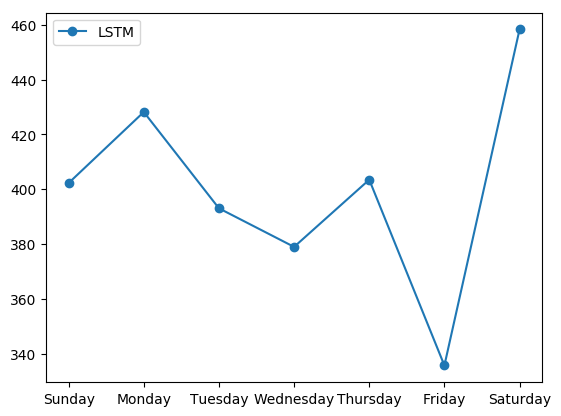

In [23]:
days = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
score, scores = evaluate_model(model=model, train=train, test=test)
sunnarize_scores("LSTM", score,scores)

plt.plot(days, scores, marker='o', label="LSTM")
plt.legend()
plt.show()